<a href="https://colab.research.google.com/github/swetharanga/CI-CD/blob/master/Crypto_Volatility_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 Initial Model Results 


--- Logistic ---

Logistic Model:
AUC: 0.6082226174286013
F1 (Class 0): 0.2376237623762376
Confusion Matrix:
 [[ 12  67]
 [ 10 111]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.15      0.24        79
           1       0.62      0.92      0.74       121

    accuracy                           0.61       200
   macro avg       0.58      0.53      0.49       200
weighted avg       0.59      0.61      0.54       200

--------------------------------------------------

--- RandomForest ---

RandomForest Model:
AUC: 1.0
F1 (Class 0): 1.0
Confusion Matrix:
 [[ 79   0]
 [  0 121]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       121

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}
AUC: 1.0
F1 (Class 0): 1.0
Confusion Matrix:
 [[ 79   0]
 [  0 121]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       121

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

--------------------------------------------------

--- Tuning MLP ---
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
AUC: 0.5342609059525054
F1 (Class 0): 0.38848920863309355
Confusion Matrix:
 [[27 52]
 [33 88]]
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.34      0.39        79
           1       0.63      0.73      0

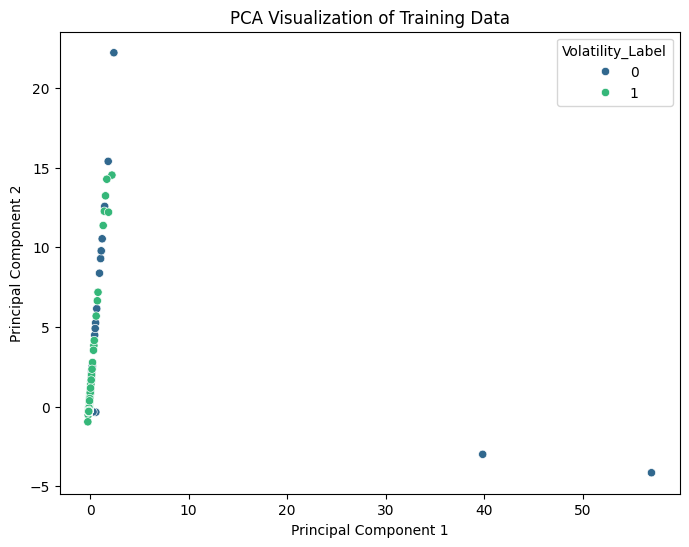

Explained variance ratio of the two principal components: [0.33838018 0.19443937]



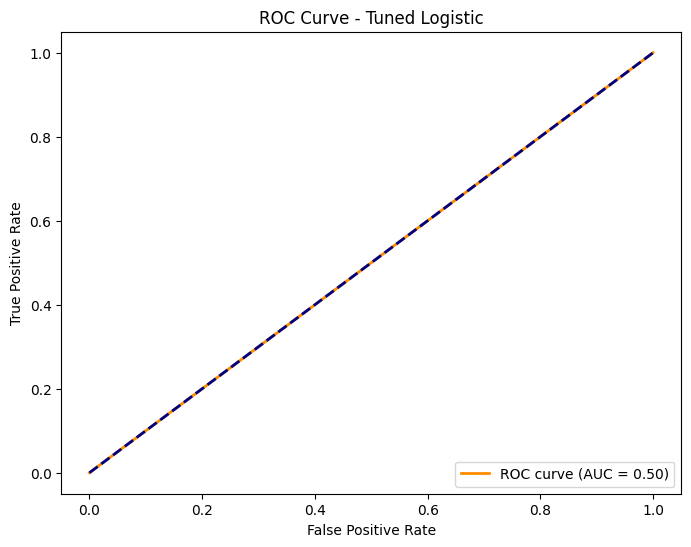

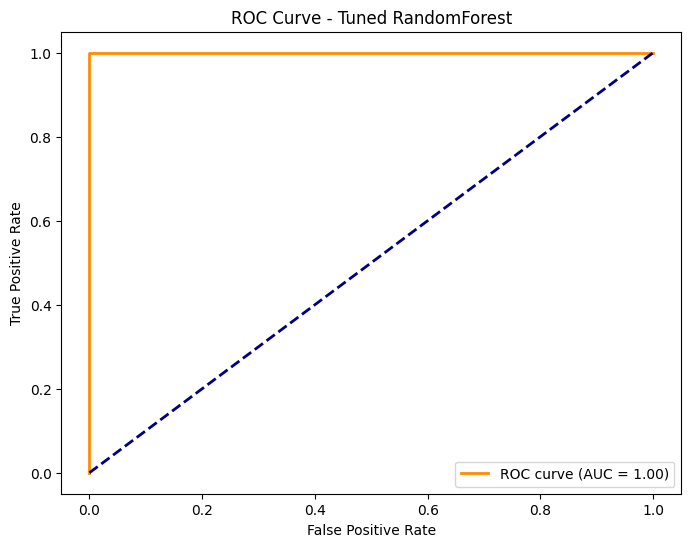

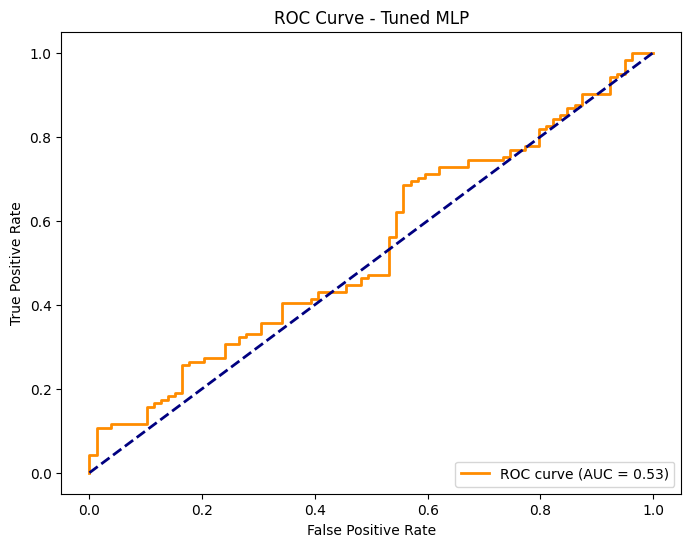

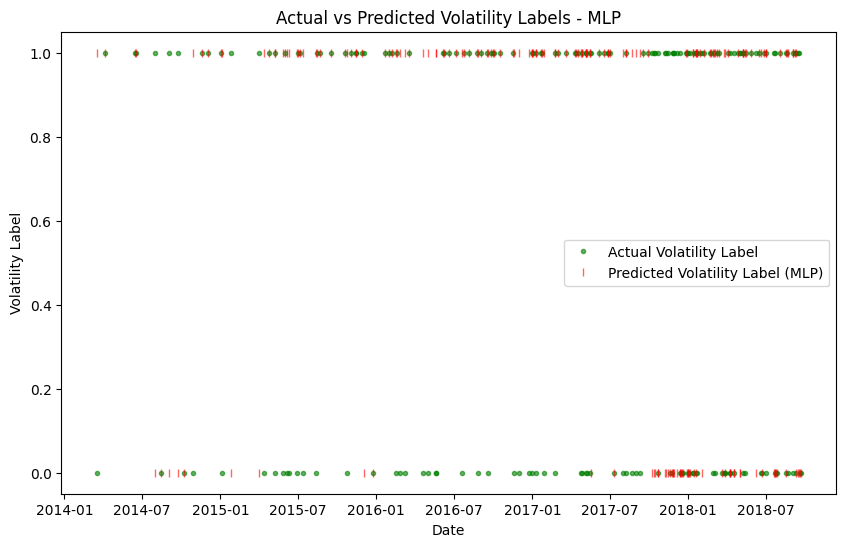

In [15]:
!pip install ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report, make_scorer, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import ta
from ta.volatility import AverageTrueRange
from sklearn.decomposition import PCA

# Load data

PATH_CRYTPO_DATA = '/content/all_currencies.csv'
df = pd.read_csv(PATH_CRYTPO_DATA, low_memory=False, skiprows=1)

# Parse date and sort the data to get valid window

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume']).copy()
df['Future_Close'] = df['Close'].shift(-1)
df['Close_Change_Percent'] = (df['Future_Close'] - df['Close']) / df['Close'] * 100
df['Volatility_Label'] = (df['Close_Change_Percent'].abs() > 5).astype(int)

df = df.sample(n=1000, random_state=42)
df = df.dropna()

# Sort and reset index

df = df.sort_values(by='Date').reset_index(drop=True)

# Calculate true range for volatility

df['True_Range'] = df[['High', 'Low', 'Close']].apply(
    lambda row: max(
        row['High'] - row['Low'],
        abs(row['High'] - row['Close']),
        abs(row['Low'] - row['Close'])
    ), axis=1
)

# Calculate next-day volatility as percent of close price

df['Next_True_Range'] = df['True_Range'].shift(-1)
df['Next_Volatility_Pct'] = df['Next_True_Range'] / df['Close'] * 100

# Binary target: 1 if volatility > 5%, else 0

df['Volatility_Label'] = (df['Next_Volatility_Pct'] > 5).astype(int)

# Drop last row with NaN in shifted column

df.dropna(subset=['Volatility_Label'], inplace=True)



def calculate_atr_ta_class(df, period=14):
    atr_indicator = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'],
    window=period)
    return atr_indicator.average_true_range()

df['ATR_14'] = calculate_atr_ta_class(df)

#  More Extensive Lagged Features

for col in ['Close', 'Volume', 'ATR_14']:
    for lag in [1, 3]:
        df[f'{col}_Lag_{lag}'] = df[col].shift(lag)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

X = df.drop(columns=['Date', 'Future_Close', 'Close_Change_Percent', 'Volatility_Label'])
y = df['Volatility_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

over = SMOTE(sampling_strategy= 1.0, random_state=42)
under = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = under.fit_resample(X_train_resampled, y_train_resampled)

# Feature scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define cross-validation and scoring

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer_minority = make_scorer(f1_score, pos_label=0)

# Define the three models

models = {
    'Logistic': LogisticRegression(class_weight='balanced', max_iter=500, random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42, early_stopping=True),
}

print("\n Initial Model Results \n")

initial_preds = {}
initial_probas = {}
for name, model in models.items():

    print(f"\n--- {name} ---")
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    initial_preds[name] = y_pred
    initial_probas[name] = y_proba

# Printing accuracy scores for each model

    print(f"\n{name} Model:")
    print("AUC:", roc_auc_score(y_test, y_proba))
    print("F1 (Class 0):", f1_score(y_test, y_pred, pos_label=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("-" * 50)

#  Hyperparameter Tuning

tuned_models = {}
tuned_preds = {}
tuned_probas = {}

param_grids = {
    'Logistic': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'penalty': ['l1', 'l2']},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10], 'min_samples_leaf': [1, 5, 10], 'class_weight': ['balanced', 'balanced_subsample']},
    'MLP': {'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)], 'activation': ['relu', 'tanh'], 'solver': ['adam', 'lbfgs'], 'alpha': [0.0001, 0.001, 0.01], 'learning_rate': ['constant', 'adaptive']}
}

print("\n  Model Results with Hyperparamter tuning")

for name, model in models.items():
    print(f"\n--- Tuning {name} ---")
    grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring=f1_scorer_minority, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train_resampled)
    best_model = grid_search.best_estimator_
    tuned_models[name] = best_model
    y_pred_tuned = best_model.predict(X_test_scaled)
    y_proba_tuned = best_model.predict_proba(X_test_scaled)[:, 1]
    tuned_preds[name] = y_pred_tuned
    tuned_probas[name] = y_proba_tuned
    print("Best Parameters:", grid_search.best_params_)
    print("AUC:", roc_auc_score(y_test, y_proba_tuned))
    print("F1 (Class 0):", f1_score(y_test, y_pred_tuned, pos_label=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
    print("Classification Report:\n", classification_report(y_test, y_pred_tuned))
    print("-" * 50)

#   PCA Visualization

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
pca_df = pd.DataFrame(data=X_train_pca, columns=['PC1', 'PC2'])
pca_df['Volatility_Label'] = y_train_resampled.values

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Volatility_Label', data=pca_df, palette='viridis')
plt.title('PCA Visualization of Training Data')
plt.xlabel(' Component 1')
plt.ylabel(' Component 2')
plt.show()

print("Explained variance ratio of the two principal components:", pca.explained_variance_ratio_)

#  ROC curve Visualization of Tuned Model Performance

for name, y_pred in tuned_preds.items():

    print()
    fpr, tpr, _ = roc_curve(y_test, tuned_probas[name])
    roc_auc = roc_auc_score(y_test, tuned_probas[name])
    plt.figure(figsize=(8, 6))

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Tuned {name}')
    plt.legend(loc='lower right')
    plt.show()

# MLP results graph

print()
mlp_test_predictions = tuned_preds['MLP']
df_test_plot = df.loc[y_test.index].copy()
df_test_plot['mlp_predicted_volatility'] = mlp_test_predictions
df_test_plot = df_test_plot.sort_values(by='Date')

plt.figure(figsize=(10, 6))
plt.plot(df_test_plot['Date'], df_test_plot['Volatility_Label'], label='Actual Volatility Label', color='green', marker='.', linestyle='None', alpha=0.6)
plt.plot(df_test_plot['Date'], df_test_plot['mlp_predicted_volatility'], label='Predicted Volatility Label (MLP)', color='red', marker='|', linestyle='None', alpha=0.6)
plt.legend()
plt.title('Actual vs Predicted Volatility Labels - MLP')
plt.xlabel('Date')
plt.ylabel('Volatility Label')
plt.show()

